In [1]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import tqdm
from time import sleep
import time
from PIL import Image
from io import BytesIO
from adjustText import adjust_text
from scipy.interpolate import interp1d
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name, get_teams, find_team_name_by_id
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail


In [2]:
from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats


In [3]:
play_types = [
    "PRBallHandler",
    "Isolation",
    "Transition",
    "Spotup",
    "Handoff",
    "OffScreen",
    "Cut",
    "OffRebound",
    "Postup",
    "PRRollman",
]

play_types_seasons = {}


    
def download_play_type_data(season='2019-20'):
    
    play_type_dict = {}
    if season not in play_types_seasons:
        print("Retrieving play types...")
        for play in play_types:
            synergy = SynergyPlayTypes(player_or_team_abbreviation='P', play_type_nullable=play, type_grouping_nullable="offensive", per_mode_simple="PerGame", season=season)
            synergy_df = synergy.get_data_frames()[0]
            play_type_dict[play] = synergy_df
            time.sleep(1)
        play_types_seasons[season] = play_type_dict
    else:
        play_type_dict = play_types_seasons[season]

    
    return play_type_dict




In [4]:
def get_interesting_data(df, target_column):
    final_df = None
    for index, play in enumerate(play_types):
        columns = ["PLAYER_NAME", target_column]
        result = df[play].loc[:, columns]
        result = result.rename(columns={target_column: f'{target_column}_{play}'})
        if index == 0:
            final_df = result
        else:
            final_df = pd.merge(left=final_df, right=result, on='PLAYER_NAME', how='outer')
    return final_df


def get_merged_data(first_year, second_year, target_column):
    
    target_columns = [
        f"{target_column}_PRBallHandler",
        f"{target_column}_Isolation",
        f"{target_column}_Transition",
        f"{target_column}_Spotup",
        f"{target_column}_Handoff",
        f"{target_column}_OffScreen",
        f"{target_column}_Cut",
        f"{target_column}_OffRebound",
        f"{target_column}_Postup",
        f"{target_column}_PRRollman",
    ]

    
    
    first_df = get_interesting_data(first_year, target_column)
    second_df = get_interesting_data(second_year, target_column)
    merged_df = pd.merge(left=first_df, right=second_df, on='PLAYER_NAME', suffixes=('_last', '_cur'))
    for play in play_types:
        merged_df.loc[:, f'{play}_diff'] = (merged_df[f'{target_column}_{play}_cur'] - merged_df[f'{target_column}_{play}_last'])**2
        
    merged_df.loc[:, "LAST_NORM"] = ((merged_df.loc[:, [f"{item}_last" for item in target_columns]]) ** 2).sum(axis=1) ** (1/2)
    merged_df.loc[:, "CUR_NORM"] = ((merged_df.loc[:, [f"{item}_cur" for item in target_columns]]) ** 2).sum(axis=1) ** (1/2)
    
    dot_product = []
    for i in range(len(merged_df)):
        last_numpy = merged_df.loc[:, [f"{item}_last" for item in target_columns]].to_numpy()[i]
        cur_numpy = merged_df.loc[:, [f"{item}_cur" for item in target_columns]].to_numpy()[i]
        dot_product.append(last_numpy.dot(cur_numpy))
    merged_df.loc[:, "DOT_PRODUCT"] = dot_product
    return merged_df
    

In [5]:
df = download_play_type_data(season='2020-21')

Retrieving play types...


In [6]:
df["PRBallHandler"].iloc[0]

SEASON_ID                    22020
PLAYER_ID                  1629027
PLAYER_NAME             Trae Young
TEAM_ID                 1610612737
TEAM_ABBREVIATION              ATL
TEAM_NAME            Atlanta Hawks
PLAY_TYPE            PRBallHandler
TYPE_GROUPING            Offensive
PERCENTILE                   0.773
GP                              64
POSS_PCT                     0.562
PPP                           0.98
FG_PCT                       0.435
FT_POSS_PCT                  0.149
TOV_POSS_PCT                 0.145
SF_POSS_PCT                  0.118
PLUSONE_POSS_PCT             0.018
SCORE_POSS_PCT               0.444
EFG_PCT                      0.494
POSS                          14.1
PTS                           13.9
FGM                            5.8
FGA                           10.2
FGMX                           5.8
Name: 0, dtype: object

In [7]:
final_data = get_interesting_data(df, target_column='PTS')

In [8]:
final_data = final_data.fillna(0.005)

In [9]:
final_data.loc[:, "SUM"] = final_data.loc[:, final_data.columns[1:]].sum(axis=1)

In [10]:
pct_points = final_data.loc[:, final_data.columns[1:]].apply(lambda row: row / row.SUM, axis=1)
pct_points.loc[:, "PLAYER_NAME"] = final_data.PLAYER_NAME

In [11]:
numpy_vals = pct_points.loc[:, pct_points.columns[:-2]].to_numpy()

In [12]:
entropies = []
for i in range(len(numpy_vals)):
    entropy = 0
    row = numpy_vals[i]
    for item in row:
        entropy += item * np.log2(item)
    entropies.append(-entropy)

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log2
  
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [13]:
final_data.loc[:, "PLAY_VERSATILITY"] = entropies

In [14]:
final_data.sort_values(by='PLAY_VERSATILITY', ascending=False)

,PLAYER_NAME,PTS_PRBallHandler,PTS_Isolation,PTS_Transition,PTS_Spotup,PTS_Handoff,PTS_OffScreen,PTS_Cut,PTS_OffRebound,PTS_Postup,PTS_PRRollman,SUM,PLAY_VERSATILITY
1407,Karl-Anthony Towns,0.400,1.900,2.100,4.400,0.800,1.800,1.600,2.600,4.400,3.700,23.700,3.081152
174,Zion Williamson,3.200,2.600,4.600,2.100,0.600,0.400,4.700,3.000,3.600,1.400,26.200,3.072597
1010,Aaron Gordon,2.000,0.700,1.800,1.800,1.200,0.005,1.000,1.100,1.800,0.600,12.005,3.068656
1011,Aaron Gordon,2.000,0.700,1.800,1.800,1.200,0.005,1.000,1.100,1.000,0.600,11.205,3.068482
1013,Aaron Gordon,2.000,0.700,1.800,1.800,1.200,0.005,1.000,1.000,1.000,0.600,11.105,3.065409
1012,Aaron Gordon,2.000,0.700,1.800,1.800,1.200,0.005,1.000,1.000,1.800,0.600,11.905,3.064951
1006,Aaron Gordon,2.000,0.700,1.800,1.800,1.200,0.005,2.300,1.100,1.800,0.600,13.305,3.059771
1008,Aaron Gordon,2.000,0.700,1.800,1.800,1.200,0.005,2.300,1.000,1.800,0.600,13.205,3.055236
1007,Aaron Gordon,2.000,0.700,1.800,1.800,1.200,0.005,2.300,1.100,1.000,0.600,12.505,3.049244
1019,Aaron Gordon,2.000,0.700,1.800,1.800,0.700,0.005,1.000,1.100,1.000,0.600,10.705,3.046253


In [15]:
final_data.sort_values(by='SUM', ascending=False).iloc[:50].sort_values(by='PLAY_VERSATILITY', ascending=False)

,PLAYER_NAME,PTS_PRBallHandler,PTS_Isolation,PTS_Transition,PTS_Spotup,PTS_Handoff,PTS_OffScreen,PTS_Cut,PTS_OffRebound,PTS_Postup,PTS_PRRollman,SUM,PLAY_VERSATILITY
174,Zion Williamson,3.200,2.6,4.6,2.1,0.600,0.400,4.700,3.000,3.600,1.400,26.200,3.072597
13,Jayson Tatum,6.800,3.9,4.3,3.5,1.600,1.300,1.100,0.500,2.000,0.600,25.600,2.934961
29,Kawhi Leonard,6.300,3.5,3.0,4.0,0.900,1.000,1.100,0.700,3.400,0.300,24.200,2.904980
1311,Nikola Jokic,0.500,1.8,1.1,3.3,0.005,1.500,2.800,3.000,6.000,4.700,24.705,2.901640
718,Kevin Durant,3.800,3.9,4.8,5.2,1.200,2.200,1.000,0.005,2.100,0.400,24.605,2.885210
115,LeBron James,5.100,3.7,5.6,2.1,0.600,0.500,2.100,0.400,3.600,0.500,24.200,2.858619
684,Giannis Antetokounmpo,2.200,4.8,8.2,2.2,0.100,0.200,3.000,1.400,3.100,1.800,27.000,2.829553
135,Jaylen Brown,3.700,1.4,6.1,6.2,2.200,1.700,1.100,0.800,0.800,0.200,24.200,2.825326
12,Devin Booker,6.700,2.6,5.1,2.9,1.600,2.700,1.200,0.300,1.200,0.005,24.305,2.815978
8,Bradley Beal,8.800,2.4,4.8,2.7,2.500,4.300,2.500,1.000,0.300,0.005,29.305,2.809541


## Tracking stats

In [16]:
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats

In [17]:
league_data = LeagueDashPtStats(season='2020-21', per_mode_simple='PerGame', pt_measure_type='Efficiency', player_or_team='Player')

In [18]:
league_df = league_data.get_data_frames()[0]

In [19]:
target_columns = ['DRIVE_PTS', 'CATCH_SHOOT_PTS', 'PULL_UP_PTS', 'PAINT_TOUCH_PTS', 'POST_TOUCH_PTS', 'ELBOW_TOUCH_PTS']
league_df = league_df.loc[:, ['TEAM_ID', 'PLAYER_ID', 'PLAYER_NAME', 'MIN', 'GP', 'POINTS'] + target_columns]

In [20]:
league_df.loc[:, 'TRACKING_SUM'] = league_df.loc[:, target_columns].sum(axis=1)

In [21]:
pct_tracking = league_df.loc[:, target_columns + ['TRACKING_SUM']].apply(lambda row: row / row.TRACKING_SUM, axis=1)
pct_tracking.loc[:, "PLAYER_ID"] = league_df.PLAYER_ID
pct_tracking.loc[:, "TEAM_ID"] = league_df.TEAM_ID
pct_tracking.loc[:, "PLAYER_NAME"] = league_df.PLAYER_NAME
pct_tracking.loc[:, "MIN"] = league_df.MIN
pct_tracking.loc[:, "POINTS"] = league_df.POINTS
pct_tracking.loc[:, "GP"] = league_df.GP
pct_tracking = pct_tracking.loc[:, ['TEAM_ID', 'PLAYER_ID', 'PLAYER_NAME', 'MIN', 'GP', 'POINTS'] + target_columns]

pct_tracking = pct_tracking.loc[(pct_tracking.MIN > 15) & (pct_tracking.GP >= 4)]
pct_tracking = pct_tracking.replace(to_replace=0.0, value=0.001)

In [22]:
numpy_vals = pct_tracking.loc[:, pct_tracking.columns[6:]].to_numpy()

entropies = []
for i in range(len(numpy_vals)):
    entropy = 0
    row = numpy_vals[i]
    for item in row:
        entropy += item * np.log2(item)
    entropies.append(-entropy)
    
pct_tracking.loc[:, 'SVI'] = entropies

In [23]:
top_20 = pct_tracking.sort_values(by='POINTS', ascending=False).iloc[:20].sort_values(by='SVI', ascending=False)

## Plotting chart

In [39]:
plt.style.use('fivethirtyeight')

In [40]:

player_imgs = {}
for i in tqdm.tqdm(range(len(top_20))):
    item = top_20.iloc[i]
    print(item.PLAYER_ID)
    try:
        url = f"https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/{item.TEAM_ID}/2020/260x190/{item.PLAYER_ID}.png"
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
    except:
        url = f"https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/latest/260x190/{item.PLAYER_ID}.png"
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
    player_imgs[item.PLAYER_ID] = img
    time.sleep(0.1)

  0%|                                                                                                                                                                                                                                               | 0/20 [00:00<?, ?it/s]

203999


  5%|███████████▌                                                                                                                                                                                                                           | 1/20 [00:00<00:06,  2.94it/s]

203954


 10%|███████████████████████                                                                                                                                                                                                                | 2/20 [00:00<00:05,  3.05it/s]

203507


 15%|██████████████████████████████████▋                                                                                                                                                                                                    | 3/20 [00:00<00:05,  3.15it/s]

1627759


 20%|██████████████████████████████████████████████▏                                                                                                                                                                                        | 4/20 [00:01<00:04,  3.21it/s]

2544


 25%|█████████████████████████████████████████████████████████▊                                                                                                                                                                             | 5/20 [00:01<00:04,  3.28it/s]

1628369


 30%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                                 | 6/20 [00:01<00:04,  3.32it/s]

201142


 35%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 7/20 [00:02<00:03,  3.38it/s]

203924


 40%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 8/20 [00:02<00:03,  3.37it/s]

202681


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 9/20 [00:02<00:03,  3.39it/s]

203078


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 10/20 [00:02<00:02,  3.41it/s]

1629012


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 11/20 [00:03<00:02,  3.39it/s]

203081


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 12/20 [00:03<00:02,  3.40it/s]

201939


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 13/20 [00:03<00:02,  3.42it/s]

1627742


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 14/20 [00:04<00:01,  3.40it/s]

202331


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 15/20 [00:04<00:01,  3.41it/s]

203897


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 16/20 [00:04<00:01,  3.41it/s]

203468


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 17/20 [00:05<00:00,  3.44it/s]

201935


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 18/20 [00:05<00:00,  2.21it/s]

1629029


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 19/20 [00:06<00:00,  2.46it/s]

1629027


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.10it/s]


In [24]:
team_mappings = {
    '1610612743': 'den',
    '1610612755': 'phi',
    '1610612749': 'mil',
    '1610612738': 'bos',
    '1610612747': 'lal',
    '1610612751': 'bkn',
    '1610612739': 'cle',
    '1610612757': 'por',
    '1610612744': 'gsw',
    '1610612740': 'nop',
    '1610612746': 'lac',
    '1610612741': 'chi',
    '1610612745': 'hou',
    '1610612742': 'dal',
    '1610612737': 'atl',
    '1610612763': 'mem',
    '1610612764': 'was',
    '1610612765': 'det'
}

In [44]:

team_igms = {}
for i in tqdm.tqdm(range(len(top_20))):
    item = top_20.iloc[i]
    team_logo = team_mappings[str(item.TEAM_ID)]
    img = Image.open(f'../../team_logos/{team_logo}.png')
    team_igms[item.TEAM_ID] = img
    time.sleep(0.1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.50it/s]


In [25]:
from matplotlib.patches import Rectangle

In [38]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
zoom = 0.1

player_root_dir = f'player_imgs/'
team_root_dir = f'../../team_logos_id/'

def get_player_img(player_id, zoom=0.5):
    #print(path)
    return OffsetImage(plt.imread(f'{player_root_dir}{player_id}.png'), zoom=zoom)

def get_team_img(team_id, zoom=zoom):
    #print(path)
    return OffsetImage(plt.imread(f'{team_root_dir}{team_id}.png'), zoom=zoom)

In [40]:
plt.style.use('fivethirtyeight')

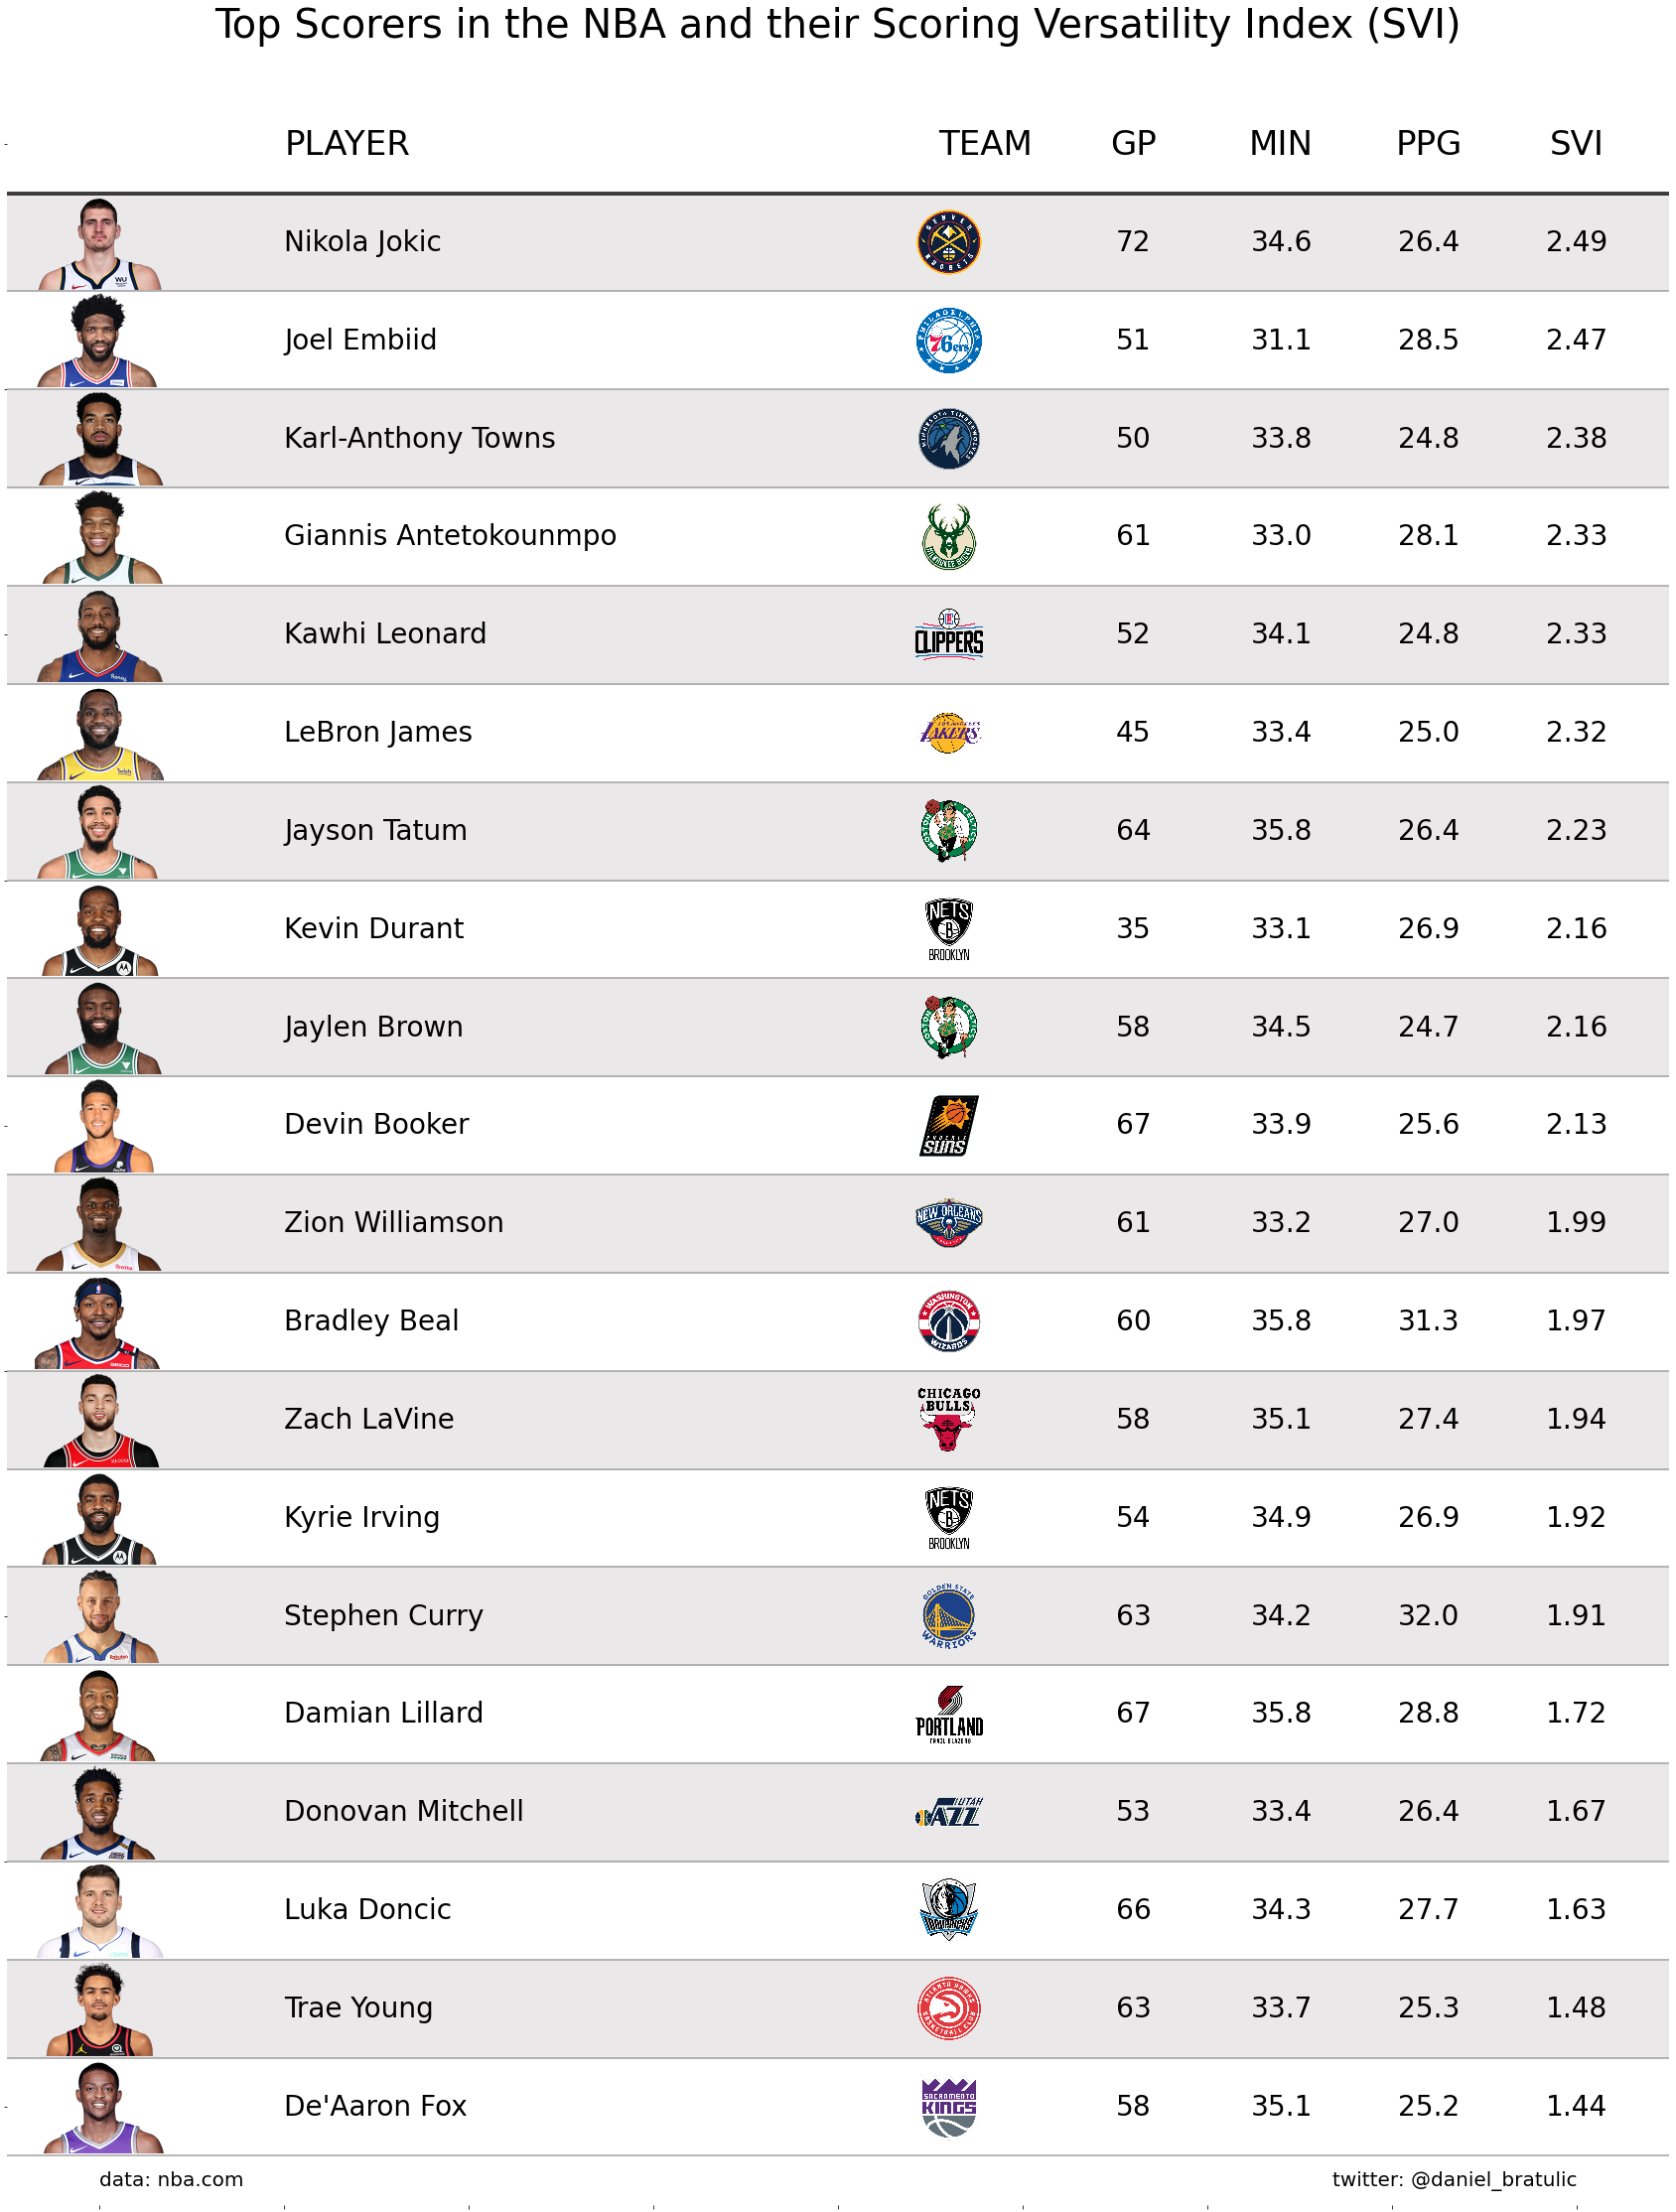

In [39]:
fig, ax = plt.subplots(figsize=(30, 40))
font_size = 28
font_title = 34
top = len(top_20)
#top = 10

for i in range(top):
    item = top_20.iloc[i]
    y_coord = top - i - 1
    if i % 2 == 1:
        color = '#EAE8E8'
        #rect = Rectangle((-0.5, y_coord + 0.5), width=5, height=1, fill=True, color=color)
        #ax.add_patch(rect)
    ax.text(x=0.5, y=y_coord, ha='left', va='center', s=item.PLAYER_NAME, size=font_size)
    ax.axhline(y=y_coord-0.5, xmin=-0.25, xmax=10, color='#A0A0A0', alpha=0.75, lw=2)
    
    
    ax.text(x=2.8, y=y_coord, ha='center', va='center', s=item.GP, size=font_size)
    ax.text(x=3.2, y=y_coord, ha='center', va='center', s=item.MIN, size=font_size)
    ax.text(x=3.6, y=y_coord, ha='center', va='center', s=item.POINTS, size=font_size)
    ax.text(x=4, y=y_coord, ha='center', va='center', s=f"{item.SVI:.2f}", size=font_size)
    
    ab = AnnotationBbox(get_player_img(item.PLAYER_ID), (0, y_coord), frameon=False)
    ax.add_artist(ab)
    team_ab = AnnotationBbox(get_team_img(item.TEAM_ID), (2.3, y_coord), frameon=False)
    ax.add_artist(team_ab)
    #ax.imshow(player_imgs[item.PLAYER_ID], extent=(0, 0.3, y_coord-0.5,y_coord + 0.5), aspect='auto', zorder=1)
    #ax.imshow(team_igms[item.TEAM_ID], extent=(2.3, 2.5, y_coord-0.35,y_coord + 0.35), aspect='auto', zorder=1)
    
    #y_img_start = y_coord-0.5 + (1 - 0.730769232) / 2
    #ax.imshow(img, extent=(0, 1.36, y_img_start-0.5, y_img_start + 0.1), aspect='auto')
    #ax.imshow(img, extent=(0, 260, 0, 190), aspect=260/190)
    
ax.text(x=0.5, y=top, s='PLAYER', ha='left', va='center', size=font_title)
ax.text(x=2.4, y=top, ha='center', va='center', s="TEAM", size=font_title)
ax.text(x=2.8, y=top, ha='center', va='center', s="GP", size=font_title)
ax.text(x=3.2, y=top, ha='center', va='center', s="MIN", size=font_title)
ax.text(x=3.6, y=top, s='PPG', ha='center', va='center', size=font_title)
ax.text(x=4, y=top, s='SVI', ha='center', va='center', size=font_title)

ax.text(x=4, y=-0.75, s='twitter: @daniel_bratulic', ha='right', va='center', size=20)
ax.text(x=0, y=-0.75, s='data: nba.com', ha='left', va='center', size=20)
ax.axhline(y=top-0.5, xmin=-0.25, xmax=10, color='black', alpha=0.75, lw=4)
ax.set_title("Top Scorers in the NBA and their Scoring Versatility Index (SVI)", size=40)
    
ax.set_ylim(bottom=-1, top=top+1)
ax.set_xlim(left=-0.25, right=4.25)
ax.grid(False)
ax.set_frame_on(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.savefig('slika.png', dpi=120, bbox_inches='tight')

In [ ]:
ax.